In [1]:
import sys
sys.path.append('../..')
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from hamp_pred.external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.output_analysis.visual import reg_plot
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

2023-04-11 20:58:10.682531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 20:58:10.816589: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-11 20:58:11.363996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-11 20:58:11.364080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)


In [3]:
data['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

## Train and validate

In [4]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
        
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [5]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod
    

In [6]:
def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 5, 7)]
    layers = [3, 5, 7]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = get_rmse(data_val, mod)
    return results
        

## Tune hiperparameters

In [7]:
res = opt_conf(data, tune=True)  

2023-04-11 20:58:17.662290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 20:58:18.210583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2023-04-11 20:58:22.767446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-11 20:58:23.004109: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 20:58:23.004827: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 20:58:23.004884: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-11 20:58:23.005701: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 20:58:23.005805: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


63/63 [==============================] - 7s 108ms/sample - loss: 0.0362 - mae: 0.1097 - val_loss: 0.0415 - val_mae: 0.1449 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0147 - mae: 0.0751 - val_loss: 0.0176 - val_mae: 0.0845 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0115 - mae: 0.0682 - val_loss: 0.0170 - val_mae: 0.0820 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 1s 23ms/sample - loss: 0.0082 - mae: 0.0586 - val_loss: 0.0165 - val_mae: 0.0778 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0057 - mae: 0.0501 - val_loss: 0.0159 - val_mae: 0.0770 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0048 - mae: 0.0462 - val_loss: 0.0162 - val_mae: 0.0779 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 1s 21ms/sample - loss: 0.0041 - mae: 0.0429 - val_loss: 0.0166 - val_mae: 0.

63/63 [==============================] - 2s 25ms/sample - loss: 0.0029 - mae: 0.0363 - val_loss: 0.0168 - val_mae: 0.0771 - lr: 0.0010
Epoch 14/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0023 - mae: 0.0322 - val_loss: 0.0152 - val_mae: 0.0733 - lr: 0.0010
Epoch 15/100
63/63 [==============================] - 2s 28ms/sample - loss: 0.0018 - mae: 0.0287 - val_loss: 0.0147 - val_mae: 0.0719 - lr: 0.0010
Epoch 16/100
63/63 [==============================] - 2s 28ms/sample - loss: 0.0017 - mae: 0.0276 - val_loss: 0.0145 - val_mae: 0.0721 - lr: 0.0010
Epoch 17/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0155 - val_mae: 0.0764 - lr: 0.0010
Epoch 18/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0016 - mae: 0.0272 - val_loss: 0.0148 - val_mae: 0.0721 - lr: 0.0010
Epoch 19/100
63/63 [==============================] - 2s 25ms/sample - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0147 - val_ma

Epoch 21/100
63/63 [==============================] - 2s 29ms/sample - loss: 0.0013 - mae: 0.0244 - val_loss: 0.0143 - val_mae: 0.0703 - lr: 1.0000e-04
Epoch 22/100
63/63 [==============================] - 2s 26ms/sample - loss: 9.6382e-04 - mae: 0.0209 - val_loss: 0.0143 - val_mae: 0.0699 - lr: 1.0000e-04
Epoch 23/100
63/63 [==============================] - 2s 26ms/sample - loss: 8.5462e-04 - mae: 0.0196 - val_loss: 0.0143 - val_mae: 0.0698 - lr: 1.0000e-04
Epoch 24/100
63/63 [==============================] - 2s 26ms/sample - loss: 7.4762e-04 - mae: 0.0184 - val_loss: 0.0143 - val_mae: 0.0700 - lr: 1.0000e-04
Epoch 25/100
63/63 [==============================] - 2s 26ms/sample - loss: 7.2961e-04 - mae: 0.0183 - val_loss: 0.0144 - val_mae: 0.0698 - lr: 1.0000e-04
Epoch 26/100
63/63 [==============================] - 2s 26ms/sample - loss: 6.5467e-04 - mae: 0.0173 - val_loss: 0.0145 - val_mae: 0.0700 - lr: 1.0000e-04
Epoch 27/100
63/63 [==============================] - 2s 25ms/sample

63/63 [==============================] - 2s 28ms/sample - loss: 6.5812e-04 - mae: 0.0178 - val_loss: 0.0142 - val_mae: 0.0688 - lr: 1.0000e-05
Epoch 30/100
63/63 [==============================] - 2s 27ms/sample - loss: 6.3473e-04 - mae: 0.0175 - val_loss: 0.0142 - val_mae: 0.0688 - lr: 1.0000e-05
Epoch 31/100
63/63 [==============================] - 2s 28ms/sample - loss: 6.4382e-04 - mae: 0.0175 - val_loss: 0.0142 - val_mae: 0.0688 - lr: 1.0000e-05
Epoch 32/100
63/63 [==============================] - 2s 28ms/sample - loss: 6.8820e-04 - mae: 0.0182 - val_loss: 0.0142 - val_mae: 0.0689 - lr: 1.0000e-05
Epoch 33/100
63/63 [==============================] - 2s 28ms/sample - loss: 6.2342e-04 - mae: 0.0173 - val_loss: 0.0142 - val_mae: 0.0689 - lr: 1.0000e-05
Epoch 34/100
63/63 [==============================] - 2s 28ms/sample - loss: 6.4468e-04 - mae: 0.0177 - val_loss: 0.0142 - val_mae: 0.0689 - lr: 1.0000e-05
Epoch 35/100
 0/63 [..............................] - ETA: 0s - loss: 6.1361e

Epoch 37/100
63/63 [==============================] - 2s 35ms/sample - loss: 5.4495e-04 - mae: 0.0158 - val_loss: 0.0137 - val_mae: 0.0674 - lr: 1.0000e-04
Epoch 38/100
63/63 [==============================] - 2s 35ms/sample - loss: 4.3793e-04 - mae: 0.0143 - val_loss: 0.0137 - val_mae: 0.0674 - lr: 1.0000e-04
Epoch 39/100
63/63 [==============================] - 2s 31ms/sample - loss: 4.2201e-04 - mae: 0.0140 - val_loss: 0.0139 - val_mae: 0.0676 - lr: 1.0000e-04
Epoch 40/100
63/63 [==============================] - 2s 32ms/sample - loss: 3.9048e-04 - mae: 0.0135 - val_loss: 0.0137 - val_mae: 0.0676 - lr: 1.0000e-04
Epoch 41/100
63/63 [==============================] - 2s 32ms/sample - loss: 3.3858e-04 - mae: 0.0126 - val_loss: 0.0140 - val_mae: 0.0677 - lr: 1.0000e-04
Epoch 42/100
63/63 [==============================] - 2s 31ms/sample - loss: 3.7771e-04 - mae: 0.0134 - val_loss: 0.0138 - val_mae: 0.0674 - lr: 1.0000e-04
Epoch 43/100
63/63 [==============================] - 2s 35ms/sa

63/63 [==============================] - 2s 34ms/sample - loss: 0.0030 - mae: 0.0365 - val_loss: 0.0158 - val_mae: 0.0802 - lr: 0.0010
Epoch 11/100
63/63 [==============================] - 2s 40ms/sample - loss: 0.0028 - mae: 0.0352 - val_loss: 0.0147 - val_mae: 0.0723 - lr: 0.0010
Epoch 12/100
63/63 [==============================] - 2s 39ms/sample - loss: 0.0025 - mae: 0.0333 - val_loss: 0.0143 - val_mae: 0.0708 - lr: 0.0010
Epoch 13/100
63/63 [==============================] - 2s 34ms/sample - loss: 0.0021 - mae: 0.0307 - val_loss: 0.0148 - val_mae: 0.0748 - lr: 0.0010
Epoch 14/100
63/63 [==============================] - 2s 39ms/sample - loss: 0.0018 - mae: 0.0283 - val_loss: 0.0142 - val_mae: 0.0714 - lr: 0.0010
Epoch 15/100
63/63 [==============================] - 2s 34ms/sample - loss: 0.0019 - mae: 0.0290 - val_loss: 0.0155 - val_mae: 0.0740 - lr: 0.0010
Epoch 16/100
63/63 [==============================] - 2s 34ms/sample - loss: 0.0027 - mae: 0.0344 - val_loss: 0.0149 - val_ma

Epoch 8/100
63/63 [==============================] - 2s 38ms/sample - loss: 0.0047 - mae: 0.0463 - val_loss: 0.0180 - val_mae: 0.0823 - lr: 0.0010
Epoch 9/100
63/63 [==============================] - 3s 42ms/sample - loss: 0.0035 - mae: 0.0393 - val_loss: 0.0150 - val_mae: 0.0721 - lr: 0.0010
Epoch 10/100
63/63 [==============================] - 3s 43ms/sample - loss: 0.0029 - mae: 0.0357 - val_loss: 0.0143 - val_mae: 0.0716 - lr: 0.0010
Epoch 11/100
63/63 [==============================] - 2s 38ms/sample - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0155 - val_mae: 0.0737 - lr: 0.0010
Epoch 12/100
63/63 [==============================] - 2s 38ms/sample - loss: 0.0030 - mae: 0.0368 - val_loss: 0.0147 - val_mae: 0.0722 - lr: 0.0010
Epoch 13/100
63/63 [==============================] - 2s 38ms/sample - loss: 0.0032 - mae: 0.0366 - val_loss: 0.0170 - val_mae: 0.0793 - lr: 0.0010
Epoch 14/100
63/63 [==============================] - 3s 42ms/sample - loss: 0.0043 - mae: 0.0436 - val_loss: 0.01

In [8]:
# kern, layers, lstm, dense
for pos, (k, v) in enumerate(sorted(res.items(), key=lambda item: item[1])):
    print(pos+1, k, round(v, 2))

1 3_5_7_7_1_3 4.22
2 3_5_7_7_2_3 4.24
3 3_5_7_5_2_1 4.27
4 3_5_7_5_1_1 4.27
5 3_5_7_7_2_1 4.28
6 3_5_7_3_1_3 4.3
7 3_5_7_3_1_1 4.32
8 3_5_7_7_1_1 4.33
9 3_5_7_5_1_3 4.35
10 3_5_7_3_2_3 4.36
11 3_5_7_5_2_3 4.36
12 3_5_7_3_2_1 4.36


## Best Config

In [39]:
model_conf = model_config = {
    'kernel_sizes': (3, 5, 7),
    'n_layers': 7,
    'lstm': 1,
    'dense': 3,
    'activation': 'tanh',
    'norm': True,
    'reshape_out': False,
    'epochs': 100
}
mod = get_mod(conf=model_conf, version='3_5_7_7_1_3')

# PDB set performance

In [40]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [41]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [42]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'HAMPpred model #1')

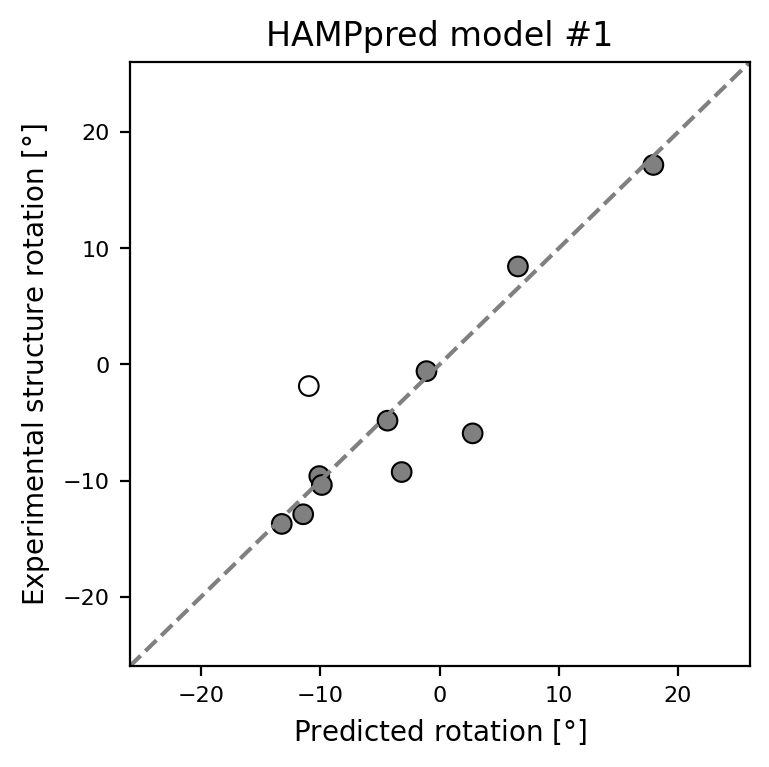

In [43]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred model #1", size=title_font_size)

In [44]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.297805398805629